## Importing Libraries

In [24]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import cv2
import pprint
import datetime
import warnings
warnings.filterwarnings('ignore')

In [29]:
parasited_paths = '/content/cell_images/Parasitized'
uninfected_paths = '/content/cell_images/Uninfected'

In [32]:
parasitized_cell_path_prefix = '/content/cell_images/Parasitized'
uninfected_cell_path_prefix = '/content/cell_images/Uninfected'

In [33]:
parasited_paths = [os.path.join(parasitized_cell_path_prefix, i) for i in os.scandir(parasitized_cell_path_prefix)]
uninfected_paths = [os.path.join(uninfected_cell_path_prefix, i) for i in os.scandir(uninfected_cell_path_prefix)]


pprint.pprint(parasited_paths[:3])
pprint.pprint(uninfected_paths[:3])

['/content/cell_images/Parasitized/C132P93ThinF_IMG_20151004_152505_cell_140.png',
 '/content/cell_images/Parasitized/C66P27N_ThinF_IMG_20150818_163419_cell_205.png',
 '/content/cell_images/Parasitized/C89P50ThinF_IMG_20150820_162300_cell_210.png']
['/content/cell_images/Uninfected/C98P59ThinF_IMG_20150917_153801_cell_127.png',
 '/content/cell_images/Uninfected/C86P47ThinF_IMG_20150820_124943_cell_78.png',
 '/content/cell_images/Uninfected/C146P107ThinF_IMG_20151018_140044_cell_142.png']


(163, 112, 3)


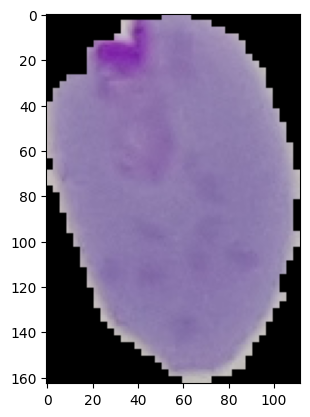

In [35]:
print(plt.imread(parasited_paths[5]).shape)
plt.imshow(plt.imread(parasited_paths[5]));

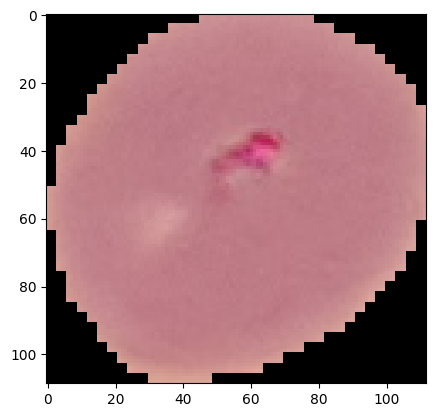

In [36]:
plt.imshow(plt.imread(uninfected_paths[5]));

In [37]:
# Create a DataFrame from full_paths of images
df_parasited = pd.DataFrame({'filename': parasited_paths, 'class': 'parasitized'})
df_uninfected = pd.DataFrame({'filename': uninfected_paths, 'class': 'uninfected'})

# Concatenate the two DataFrames
df = pd.concat([df_parasited, df_uninfected], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Display a sample of the training and testing sets
print("Length of train Set: ", len(train_df))
print("Training set:")
print(train_df.head())
print("\nLength of test Set: ", len(test_df))
print("Testing set:")
print(test_df.head())

Length of train Set:  24804
Training set:
                                                filename        class
23886  /content/cell_images/Uninfected/C96P57ThinF_IM...   uninfected
19633  /content/cell_images/Parasitized/C184P145ThinF...  parasitized
17781  /content/cell_images/Parasitized/C136P97ThinF_...  parasitized
19612  /content/cell_images/Parasitized/C176P137NThin...  parasitized
13033  /content/cell_images/Uninfected/C104P65ThinF_I...   uninfected

Length of test Set:  2756
Testing set:
                                                filename        class
2476   /content/cell_images/Uninfected/C102P63ThinF_I...   uninfected
7809   /content/cell_images/Parasitized/C68P29N_ThinF...  parasitized
18968  /content/cell_images/Uninfected/C117P78ThinF_I...   uninfected
10810  /content/cell_images/Parasitized/C176P137NThin...  parasitized
13698  /content/cell_images/Parasitized/C46P7ThinF_IM...  parasitized


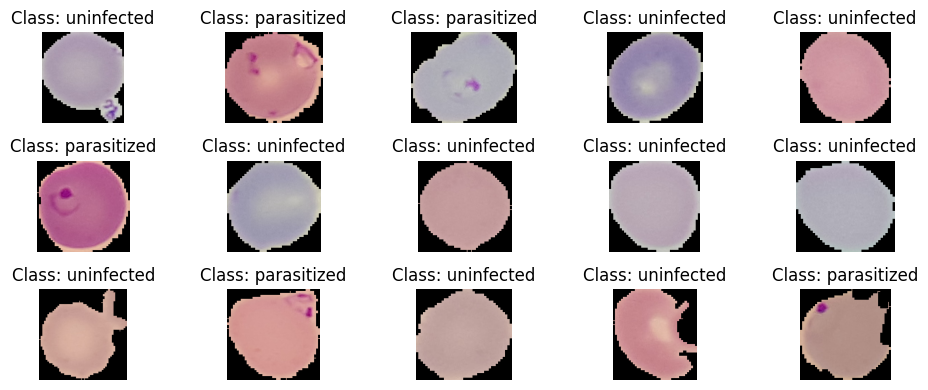

In [38]:
# Create a subplot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 4))
axes = axes.flatten()

# Plotting images
for i in range(15):
    ax = axes[i]

    sample_observation = train_df.sample()
    sample_path = sample_observation['filename'].iloc[0]

    image = plt.imread(sample_path)

    ax.imshow(image)
    ax.set_title(f"Class: {sample_observation['class'].iloc[0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Train set, Uninfected Images: 12396
Train set, Parasitized Images: 12408
Test set, Uninfected Images: 1384
Test set, Parasitized Images: 1372


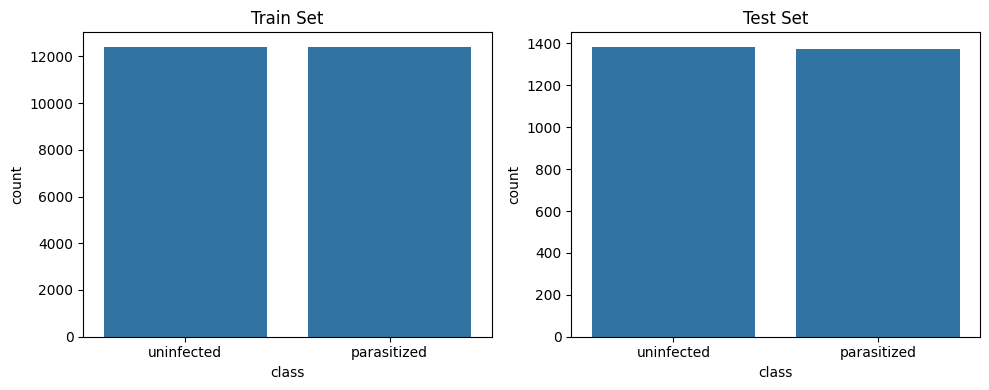

In [39]:
print(f"Train set, Uninfected Images: {len(train_df[train_df['class']=='uninfected'])}")
print(f"Train set, Parasitized Images: {len(train_df[train_df['class']=='parasitized'])}")
print(f"Test set, Uninfected Images: {len(test_df[test_df['class']=='uninfected'])}")
print(f"Test set, Parasitized Images: {len(test_df[test_df['class']=='parasitized'])}")

fig,axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=train_df['class'], ax=axes[0])
axes[0].set_title('Train Set')
sns.countplot(x=test_df['class'], ax=axes[1])
axes[1].set_title('Test Set')
plt.tight_layout()
plt.show()

In [40]:
# random 200 images

random_images_paths = train_df.sample(200)['filename']
x = []
y = []
c = []
max_rgb = []
min_rgb = []

for image_path in random_images_paths:
    image = plt.imread(image_path)

    max_rgb.append(image.max())
    min_rgb.append(image.min())

    d1, d2, channels = image.shape
    x.append(d1)
    y.append(d2)
    c.append(channels)

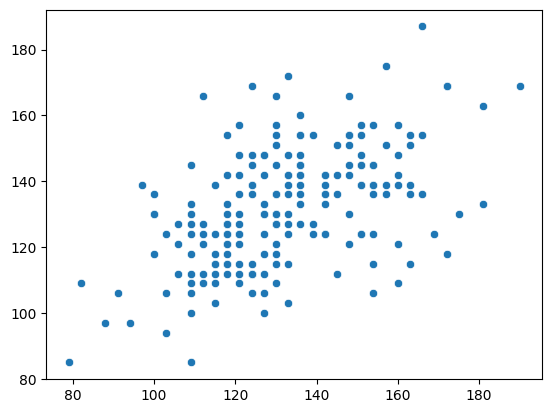

In [41]:
sns.scatterplot(x=x,y=y);

In [42]:
print(np.mean(x),'--', np.mean(y))

131.98 -- 131.92


In [43]:
print(f"Unique Channels: {set(c)}")

Unique Channels: {3}


In [45]:
batch_size = 64
image_shape = (135,135,3)
target_size = (135,135)

In [46]:
# train set (divided into train and validation set: validation set will be used within the model)

train_image_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Separate generators for training and validation
train_generator = train_image_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  
    seed=42,
    subset='training'
)

validation_generator = train_image_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42,
    subset='validation'
)

Found 19842 validated image filenames belonging to 2 classes.
Found 4960 validated image filenames belonging to 2 classes.


In [47]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(len(train_generator))
print(len(validation_generator))

{'parasitized': 0, 'uninfected': 1}
{'parasitized': 0, 'uninfected': 1}
311
78


In [48]:
x_test = test_df.copy()
test_images = x_test['filename']
test_labels = x_test['class']

loaded_images = []

for path in test_images:
    img = cv2.imread(path)
    resized_img = cv2.resize(img, dsize=target_size, interpolation=cv2.INTER_AREA)
    loaded_images.append(resized_img)

loaded_images 2756 qty np.arrays [images] in a list
test_images 2756 of <class 'pandas.core.series.Series'>
test_labels 2756 of <class 'pandas.core.series.Series'>
Shape of an image from Test Set: (135, 135, 3)


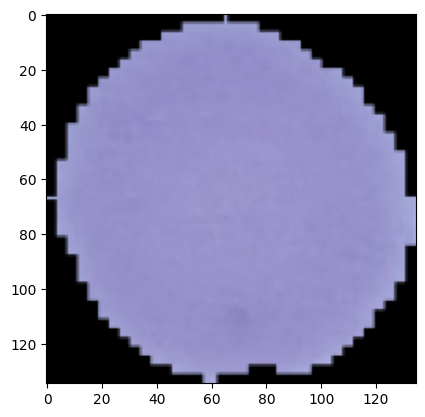

In [49]:
print(f"loaded_images {len(loaded_images)} qty np.arrays [images] in a list")
print(f"test_images {len(test_images)} of {type(test_images)}")
print(f"test_labels {len(test_labels)} of {type(test_labels)}")
print(f"Shape of an image from Test Set: {loaded_images[42].shape}")

plt.imshow(loaded_images[42])
plt.show()

(135, 135, 3)
Image saved as: /content/workingaugmented_image.jpg


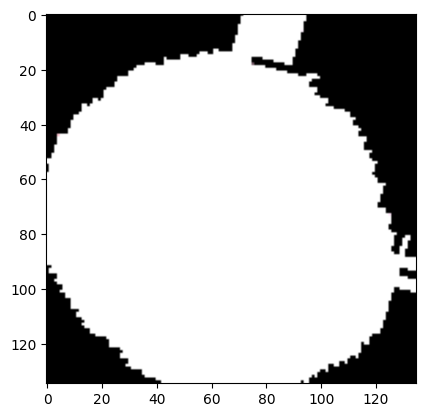

In [51]:
augmented_img = next(train_generator)[0][0]  # batch_size=1
print(augmented_img.shape)

# image saving
filename = "augmented_image.jpg"
path = f"/content/working{filename}"

from PIL import Image
img = Image.fromarray(augmented_img.astype('uint8'))
img.save(path)

print(f"Image saved as: {path}")

# image
plt.imshow(augmented_img)
plt.show()

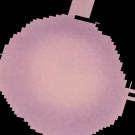

In [52]:
from IPython.display import Image
image_path = '/content/workingaugmented_image.jpg'
Image(filename=image_path, width=400)

In [53]:
# number of batches for model training
print(len(train_generator))
print(len(validation_generator))

311
78


## Customized CNN Model

In [54]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 135, 135, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 67, 67, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 67, 67, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 33, 33, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 33, 33, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 128)      

In [55]:
results = model.fit(
    train_generator,
    steps_per_epoch= 50,   
    epochs=10,
    validation_data=validation_generator,
    batch_size=batch_size
)

Epoch 1/10
50/50 [==============================] - 52s 944ms/step - loss: 1.3986 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.4944
Epoch 2/10
50/50 [==============================] - 46s 934ms/step - loss: 0.6919 - accuracy: 0.5366 - val_loss: 0.6740 - val_accuracy: 0.6077
Epoch 3/10
50/50 [==============================] - 46s 927ms/step - loss: 0.6944 - accuracy: 0.5220 - val_loss: 0.6835 - val_accuracy: 0.6121
Epoch 4/10
50/50 [==============================] - 59s 1s/step - loss: 0.6777 - accuracy: 0.5913 - val_loss: 0.6753 - val_accuracy: 0.5506
Epoch 5/10
50/50 [==============================] - 45s 914ms/step - loss: 0.5353 - accuracy: 0.7441 - val_loss: 0.4264 - val_accuracy: 0.8458
Epoch 6/10
50/50 [==============================] - 47s 942ms/step - loss: 0.2996 - accuracy: 0.9069 - val_loss: 0.2268 - val_accuracy: 0.9327
Epoch 7/10
50/50 [==============================] - 47s 942ms/step - loss: 0.2272 - accuracy: 0.9366 - val_loss: 0.1670 - val_accuracy: 0.9470
Ep

       loss  accuracy  val_loss  val_accuracy
0  1.398588  0.500000  0.694593      0.494355
1  0.691860  0.536563  0.674035      0.607661
2  0.694408  0.521989  0.683479      0.612097
3  0.677735  0.591250  0.675311      0.550605
4  0.535333  0.744062  0.426410      0.845766

 ----------------------------------------------------------------------------------------------------


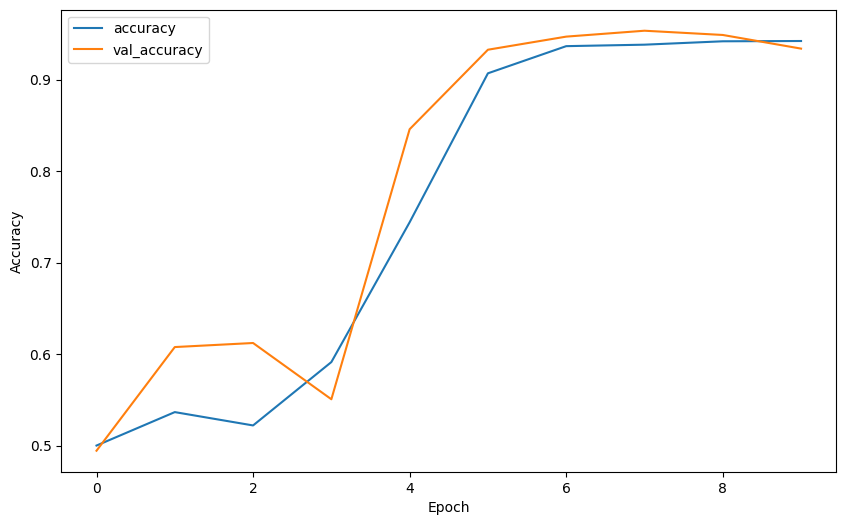

In [56]:
# Model Summary
summary = pd.DataFrame(model.history.history)
print(summary.head())
print('\n','-'*100)

plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [57]:
# Model Evaluation on Test Set

# Convert the list of loaded images to a numpy array
test_images_array = np.array(loaded_images)

# Make predictions using the model
predictions = model.predict(test_images_array)

# Convert the predictions to binary labels 
predicted_labels = np.round(predictions).flatten().astype(int)

# Convert the actual labels from strings to integers 
actual_labels = (test_labels == 'uninfected').astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == actual_labels)

print(f"Accuracy score is {accuracy}")

87/87 [==============================] - 1s 13ms/step
Accuracy score is 0.9368650217706821


## ResNet50

In [58]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape= image_shape
)

# Freezing the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Resnet50
model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               13107456  
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                       

In [59]:
results = model.fit(
    train_generator,
    steps_per_epoch= 50,    
    epochs=10,
    validation_data=validation_generator,
    batch_size=batch_size
)

Epoch 1/10
50/50 [==============================] - 56s 1s/step - loss: 3.2423 - accuracy: 0.7525 - val_loss: 0.2904 - val_accuracy: 0.8804
Epoch 2/10
50/50 [==============================] - 48s 978ms/step - loss: 0.3433 - accuracy: 0.8653 - val_loss: 0.2466 - val_accuracy: 0.8980
Epoch 3/10
50/50 [==============================] - 48s 980ms/step - loss: 0.2964 - accuracy: 0.8844 - val_loss: 0.2377 - val_accuracy: 0.9040
Epoch 4/10
50/50 [==============================] - 47s 960ms/step - loss: 0.2916 - accuracy: 0.8853 - val_loss: 0.2359 - val_accuracy: 0.9018
Epoch 5/10
50/50 [==============================] - 49s 985ms/step - loss: 0.2730 - accuracy: 0.8944 - val_loss: 0.2282 - val_accuracy: 0.9062
Epoch 6/10
50/50 [==============================] - 48s 979ms/step - loss: 0.2502 - accuracy: 0.9022 - val_loss: 0.2182 - val_accuracy: 0.9093
Epoch 7/10
50/50 [==============================] - 51s 1s/step - loss: 0.2629 - accuracy: 0.8900 - val_loss: 0.2286 - val_accuracy: 0.9036
Epoch

       loss  accuracy  val_loss  val_accuracy
0  3.242338  0.752500  0.290421      0.880444
1  0.343266  0.865313  0.246554      0.897984
2  0.296380  0.884375  0.237661      0.904032
3  0.291592  0.885312  0.235941      0.901815
4  0.273016  0.894375  0.228157      0.906250

 ----------------------------------------------------------------------------------------------------


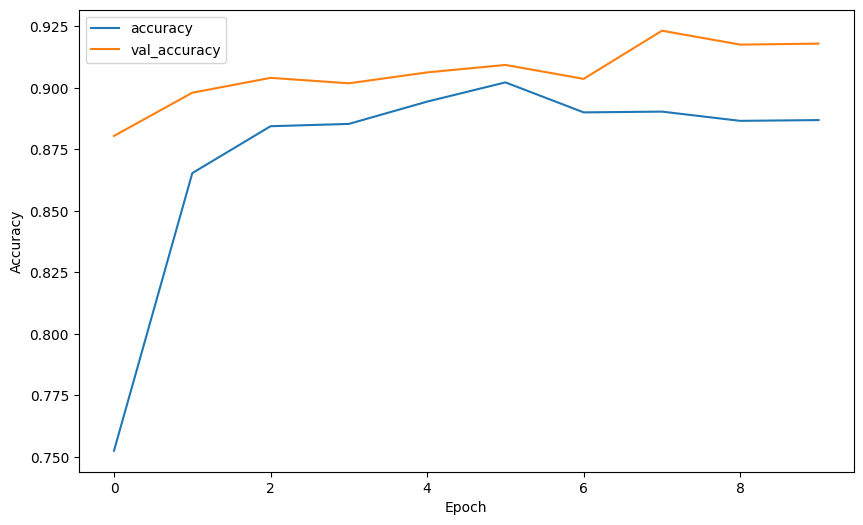

In [60]:
# Model Summary
summary = pd.DataFrame(model.history.history)
print(summary.head())
print('\n','-'*100)

plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [61]:
# Model Evaluation on Test Set

# Convert the list of loaded images to a numpy array
test_images_array = np.array(loaded_images)

# Make predictions using the model
predictions = model.predict(test_images_array)

# Convert the predictions to binary labels 
predicted_labels = np.round(predictions).flatten().astype(int)

# Convert the actual labels from strings to integers 
actual_labels = (test_labels == 'uninfected').astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == actual_labels)

print(f"Accuracy score is {accuracy}")

87/87 [==============================] - 6s 55ms/step
Accuracy score is 0.8940493468795355


## EfficientNetB2

In [62]:
base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape= image_shape
)

# Freezing the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# EfficientNetB2
model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 5, 5, 1408)        7768569   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 35200)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               9011456   
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 

In [63]:
results = model.fit(
    train_generator,
    steps_per_epoch= 50,    
    epochs=10,
    validation_data=validation_generator,
    batch_size=batch_size
)

Epoch 1/10
50/50 [==============================] - 65s 1s/step - loss: 1.4847 - accuracy: 0.8041 - val_loss: 0.2560 - val_accuracy: 0.8968
Epoch 2/10
50/50 [==============================] - 50s 1s/step - loss: 0.2783 - accuracy: 0.8925 - val_loss: 0.2332 - val_accuracy: 0.9105
Epoch 3/10
50/50 [==============================] - 49s 988ms/step - loss: 0.2464 - accuracy: 0.9091 - val_loss: 0.2124 - val_accuracy: 0.9236
Epoch 4/10
50/50 [==============================] - 59s 1s/step - loss: 0.2810 - accuracy: 0.8950 - val_loss: 0.1891 - val_accuracy: 0.9347
Epoch 5/10
50/50 [==============================] - 52s 1s/step - loss: 0.2454 - accuracy: 0.9009 - val_loss: 0.1847 - val_accuracy: 0.9317
Epoch 6/10
50/50 [==============================] - 48s 961ms/step - loss: 0.2373 - accuracy: 0.9041 - val_loss: 0.1864 - val_accuracy: 0.9308
Epoch 7/10
50/50 [==============================] - 52s 1s/step - loss: 0.2577 - accuracy: 0.8953 - val_loss: 0.1781 - val_accuracy: 0.9363
Epoch 8/10
50/

       loss  accuracy  val_loss  val_accuracy
0  1.484711  0.804062  0.255994      0.896774
1  0.278332  0.892500  0.233218      0.910484
2  0.246357  0.909063  0.212419      0.923589
3  0.280967  0.895000  0.189122      0.934677
4  0.245388  0.900937  0.184667      0.931653

 ----------------------------------------------------------------------------------------------------


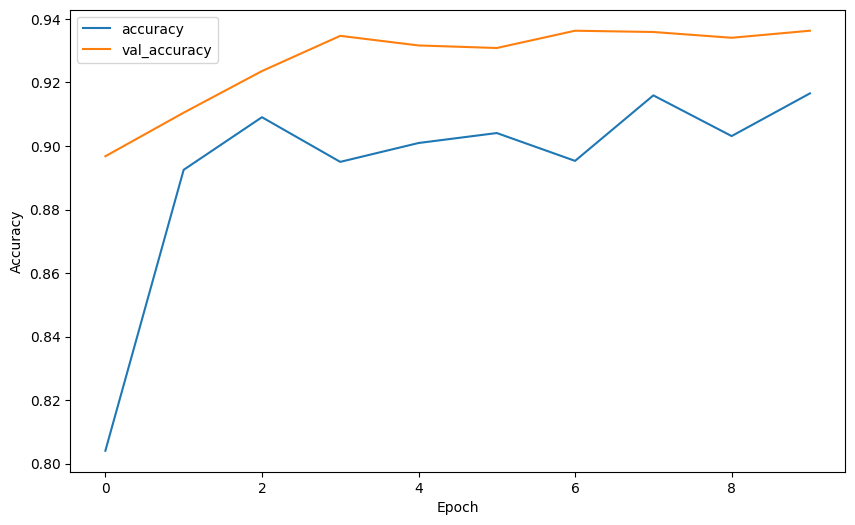

In [64]:
# Model Summary
summary = pd.DataFrame(model.history.history)
print(summary.head())
print('\n','-'*100)

plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [65]:
# Model Evaluation on Test Set

# Convert the list of loaded images to a numpy array
test_images_array = np.array(loaded_images)

# Make predictions using the model
predictions = model.predict(test_images_array)

# Convert the predictions to binary labels
predicted_labels = np.round(predictions).flatten().astype(int)

# Convert the actual labels from strings to integers 
actual_labels = (test_labels == 'uninfected').astype(int)

# Accuracy
accuracy = np.mean(predicted_labels == actual_labels)

print(f"Accuracy score is {accuracy}")

87/87 [==============================] - 6s 50ms/step
Accuracy score is 0.9437590711175616
